# Import packages

In [1]:
####import packages
using FFTW
using Distributions
#using NBInclude
#using Plots
using PyCall
using PyPlot
#using WebIO
using Pkg
using Interpolations
using LinearAlgebra
using Profile
using TensorOperations
import NaNMath
using DelimitedFiles
using Wavelets

#get to the root of the project to ease path later on
if pwd()[end-7:end] == "Analysis"
    cd("..")
end

###import local files (CAUTION: kernel must be restarted if changes are made)
include("src/Coupling.jl") 
include("src/CouplingOptimization.jl")
include("src/Phase.jl") 
include("src/PhaseSim.jl") 
include("src/URTS.jl") 
include("src/SignalAnalysis.jl") 

#@nbinclude("Types.ipynb")

###set nice plotting style
@pyimport matplotlib.pyplot as p
p.style[:use]("seaborn-whitegrid")



# Store parameters condition and traces in a dict

In [2]:
d_cond = Dict()
for namedir in readdir("Data")
    if namedir==".DS_Store"
        continue
    end
    
    #get list of real parameters
    l_param = readdlm("Data/"*namedir*"/Parameters/original.txt")
    
    #get traces
    l_traces = []
    for name_idx_trace in readdir("Data/"*namedir*"/Traces")
        trace = readdlm("Data/"*namedir*"/Traces/"*name_idx_trace)
        push!(l_traces,trace)
    end
    
    #add traces to dictionnary
    d_cond[l_param] = l_traces
end        

# Infer parameters

First, smooth signal and detect maxima/minima

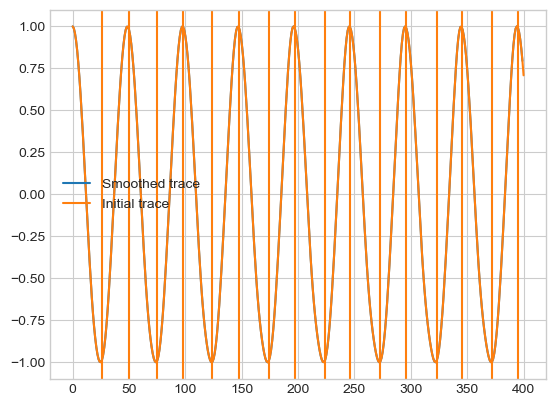

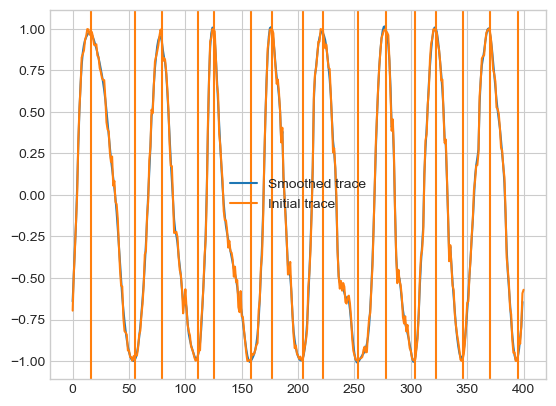

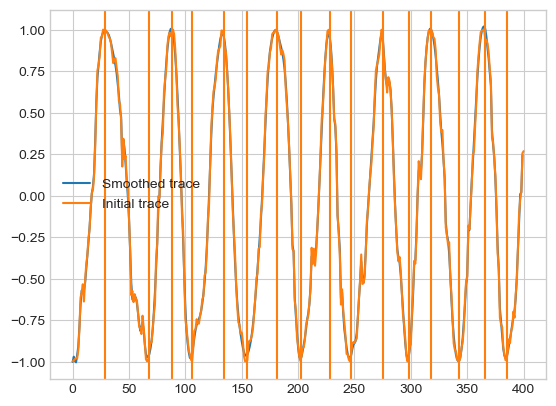

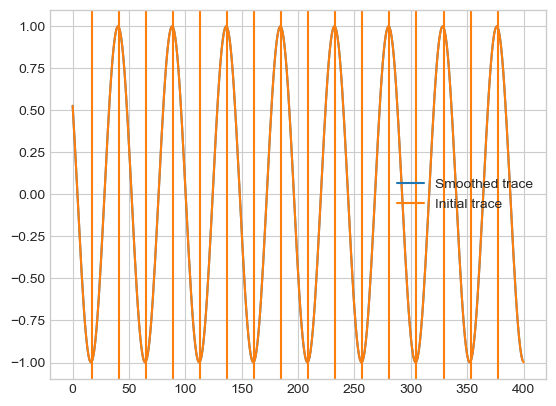

In [3]:
 d_extrema = Dict()
plt = true
#in the end, use visushrink denoising
for (l_param, l_traces) in d_cond
    ll_extrema = []
    ll_smoothed_signal = []
    for (idx, trace) in enumerate(l_traces)
        #first remove high frequency noise (mainly extrinsic noise)
        smoothed_trace_theta = denoise(trace[1:end-1,3],TI=true)  
        smoothed_trace_phi = denoise(trace[1:end-1,4],TI=true)   
        #smooth the resulting signal to remove remaining noise (mainly intrinsic)
        #smoothed_trace_theta = smooth(denoised_trace_theta, 0.95)
        #smoothed_trace_phi = smooth(denoised_trace_phi, 0.95)
        #compute extrema
        l_extrema_theta = return_maxima_indexes(smoothed_trace_theta)
        l_extrema_phi = return_maxima_indexes(smoothed_trace_phi)
        push!(ll_extrema, [l_extrema_theta, l_extrema_phi])
        push!(ll_smoothed_signal, [smoothed_trace_theta, smoothed_trace_phi])
        if plt
            if idx==1
                figure()
                plot(smoothed_trace_theta, label = "Smoothed trace")
                l_extrema = return_maxima_indexes(smoothed_trace_theta)
                plot(trace[:,3], label = "Initial trace")
                for x in l_extrema
                    axvline(x, color = "C1")
                end
                legend()
                show()
            end
        end    
    end 
    d_extrema[l_param] = (ll_extrema, ll_smoothed_signal)
end
        


## Infer phase diffusion parameter 

In [4]:
d_parameters = Dict()
for (l_param, (ll_extrema, ll_smoothed_signal)) in d_extrema
    l_period_theta = []
    l_period_phi = []
    for (l_extrema_theta, l_extrema_phi) in ll_extrema
        l_period_theta_1 = l_extrema_theta[3:2:end]-l_extrema_theta[1:2:end-2]
        l_period_theta_2 = l_extrema_theta[4:2:end]-l_extrema_theta[2:2:end-2]
        l_period_phi_1 = l_extrema_phi[3:2:end]-l_extrema_phi[1:2:end-2]
        l_period_phi_2 = l_extrema_phi[4:2:end]-l_extrema_phi[2:2:end-2]
        l_period_theta = vcat(l_period_theta, vcat(l_period_theta_1,l_period_theta_2))
        l_period_phi = vcat(l_period_phi, vcat( l_period_phi_1, l_period_phi_2))
    end
    sigma_theta = sqrt(var(l_period_theta)*4*π^2/mean(l_period_theta)^3)
    sigma_phi = sqrt(var(l_period_phi)*4*π^2/mean(l_period_phi)^3)
    sigma_theta_theo = l_param[5]
    sigma_phi_theo = l_param[6]
    
    #println("σ_θ ", sigma_theta, " ", sigma_theta_theo)
    #println("σ_ϕ ", sigma_phi, " ", sigma_phi_theo)
    #println("  ")
    d_parameters[l_param] = [sigma_theta, sigma_phi]
   
end

## Infer amplitude parameters (can be improved by improving peak detection)

In [5]:
#compute amplitude parameters
for (l_param, (ll_extrema, ll_smoothed_signal)) in d_extrema
    
    l_amplitude_theta = []
    l_amplitude_phi = []
    
    l_period_theta = []
    l_period_phi = []
    
    l_Stdt_theta = []
    l_St_theta = []
    
    l_Stdt_phi = []
    l_St_phi = []
    
    
    for ((l_extrema_theta, l_extrema_phi), (l_smooth_theta, l_smooth_phi)) in zip(ll_extrema, ll_smoothed_signal)
        
        amplitude_theta_current_trace = abs.(l_smooth_theta[l_extrema_theta[2:end]]-l_smooth_theta[l_extrema_theta[1:end-1]])/2
        amplitude_phi_current_trace = abs.(l_smooth_phi[l_extrema_phi[2:end]]-l_smooth_phi[l_extrema_phi[1:end-1]])/2
        
        l_amplitude_theta = vcat(l_amplitude_theta, amplitude_theta_current_trace)
        l_amplitude_phi = vcat(l_amplitude_phi, amplitude_phi_current_trace)
        
        period_theta_current_trace = l_extrema_theta[2:1:end]-l_extrema_theta[1:1:end-1]
        period_phi_current_trace = l_extrema_phi[2:1:end]-l_extrema_phi[1:1:end-1]
        
        l_period_theta = vcat(l_period_theta, period_theta_current_trace)
        l_period_phi = vcat(l_period_phi, period_phi_current_trace)
        
        
        l_St_theta = vcat(l_St_theta, amplitude_theta_current_trace[1:end-1])
        l_Stdt_theta = vcat(l_Stdt_theta, amplitude_theta_current_trace[2:end])
        
        l_Stdt_phi = vcat(l_Stdt_phi, amplitude_phi_current_trace[1:end-1])
        l_St_phi = vcat(l_St_phi, amplitude_phi_current_trace[2:end])
        #break
    end
    
    #first compute the time regression constant from both peak and troughts    
    b_theta = cor(l_St_theta,l_Stdt_theta)
    b_phi = cor(l_St_phi,l_Stdt_phi)
    
    #gamma_A_theta = b_theta>0 ? -log(b_theta)/mean(l_period_theta) : 0
    #gamma_A_phi = b_phi>0 ? -log(b_phi)/mean(l_period_phi) : 0
    
    gamma_A_theta = 0.1
    gamma_A_phi = 0.1
        
    mu_A_theta = mean(l_amplitude_theta)
    mu_A_phi = mean(l_amplitude_phi)
    
    sigma_A_theta = sqrt(2*gamma_A_theta*var(l_amplitude_theta))
    sigma_A_phi = sqrt(2*gamma_A_phi*var(l_amplitude_phi))
        
    println("gamma", gamma_A_theta)
    println("mu ", mu_A_theta)
    println("sigma ", sigma_A_theta)
    #println(" ")
        
    #figure()
    #plot(ll_smoothed_signal[1][1], label = "Smoothed trace")
    #legend()
    #show()
    #break
    
    d_parameters[l_param] =  vcat(d_parameters[l_param], [mu_A_theta, gamma_A_theta, sigma_A_theta, mu_A_phi, gamma_A_phi, sigma_A_phi])  
end
        

gamma0.1
mu 0.9165292860539661
sigma 0.10153293944135543
gamma0.1
mu 0.8527033144205544
sigma 0.1292888065708185
gamma0.1
mu 0.9736182557339128
sigma 0.06143836270291564
gamma0.1
mu 0.9989920209335988
sigma 0.0002689820634696891


## Infer background parameters (can be improved by improving peak detection)

In [6]:
for (idx,(l_param, (ll_extrema, ll_smoothed_signal))) in enumerate(d_extrema)
    #if idx!=3
    #    continue
    #end
    
    l_background_theta = []
    l_background_phi = []
    
    l_period_theta = []
    l_period_phi = []
    
    l_Stdt_theta = []
    l_St_theta = []
    
    l_Stdt_phi = []
    l_St_phi = []
    
    
    for ((l_extrema_theta, l_extrema_phi), (l_smooth_theta, l_smooth_phi)) in zip(ll_extrema, ll_smoothed_signal)

        initial_index_theta = l_smooth_theta[l_extrema_theta[1]]>l_smooth_theta[l_extrema_theta[2]] ? 2 : 1
        initial_index_phi = l_smooth_phi[l_extrema_phi[1]]>l_smooth_phi[l_extrema_phi[2]] ? 2 : 1
        
        background_theta_current_trace = l_smooth_theta[l_extrema_theta[initial_index_theta:2:end]]
        background_phi_current_trace = l_smooth_phi[l_extrema_phi[initial_index_phi:2:end]]
        
        #correct for peak detection problems
        if mean(background_theta_current_trace)>mean(l_smooth_theta) || mean(background_phi_current_trace)>mean(l_smooth_phi)
            continue
        end
        
        l_background_theta = vcat(l_background_theta, background_theta_current_trace)
        l_background_phi = vcat(l_background_phi, background_phi_current_trace)
        
        period_theta_current_trace =  l_extrema_theta[initial_index_theta+2:2:end]-l_extrema_theta[initial_index_theta:2:end-2]
        period_phi_current_trace = l_extrema_phi[initial_index_phi+2:2:end]-l_extrema_phi[initial_index_phi:2:end-2]
        
        l_period_theta = vcat(l_period_theta, period_theta_current_trace)
        l_period_phi = vcat(l_period_phi, period_phi_current_trace)
                
        
        l_St_theta = vcat(l_St_theta, background_theta_current_trace[1:end-1])
        l_Stdt_theta = vcat(l_Stdt_theta, background_theta_current_trace[2:end])
        
        l_Stdt_phi = vcat(l_Stdt_phi, background_phi_current_trace[1:end-1])
        l_St_phi = vcat(l_St_phi, background_phi_current_trace[2:end])
        
        #figure()
        #plot(l_smooth_theta, label = "Smoothed trace")
        #for x in l_extrema_theta
        #    axvline(x)
        #end
        #legend()
        #show()
        
        #println(background_theta_current_trace)
        
        #break
    end
    #first compute the time regression constant from both peak and troughts    
    b_theta = cor(l_St_theta,l_Stdt_theta)
    b_phi = cor(l_St_phi,l_Stdt_phi)
    
    #gamma_B_theta = b_theta>0 ? -log(b_theta)/mean(l_period_theta) : 0
    #gamma_B_phi = b_phi>0 ? -log(b_phi)/mean(l_period_phi) : 0
    
    gamma_B_theta = 0.1
    gamma_B_phi = 0.1
        
    mu_B_theta = mean(l_background_theta)
    mu_B_phi = mean(l_background_phi)
    
    sigma_B_theta = sqrt(2*gamma_B_theta*var(l_background_theta))
    sigma_B_phi = sqrt(2*gamma_B_phi*var(l_background_phi))
        
    println("gamma", gamma_B_theta)
    println("mu ", mu_B_theta)
    println("sigma ", sigma_B_theta)
    println(" ")
    
    d_parameters[l_param] =  vcat(d_parameters[l_param], [mu_B_theta, gamma_B_theta, sigma_B_theta, mu_B_phi, gamma_B_phi, sigma_B_phi])  

end


gamma0.1
mu -0.9388523279276613
sigma 0.10880403504159868
 
gamma0.1
mu -0.7228870033828696
sigma 0.26623872530587106
 
gamma0.1
mu -0.9015819740554154
sigma 0.18494157563240105
 
gamma0.1
mu -0.9989928987320595
sigma 0.0002687393892392944
 


## Infer waveforms (only for uncoupled signals)

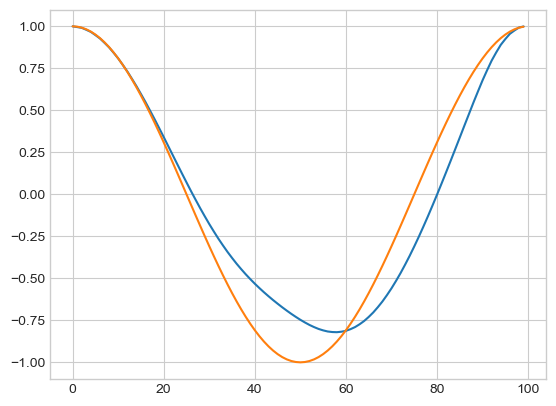

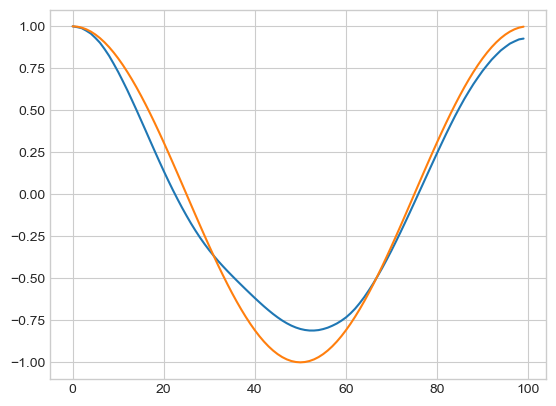

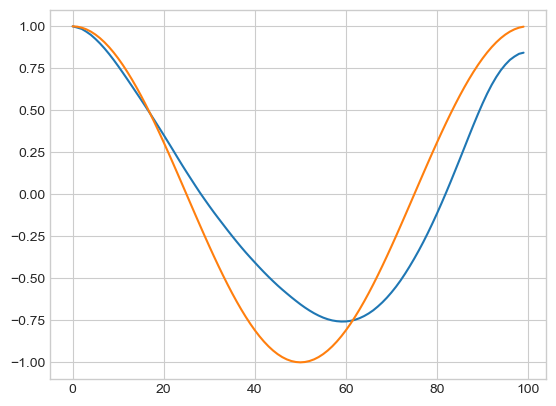

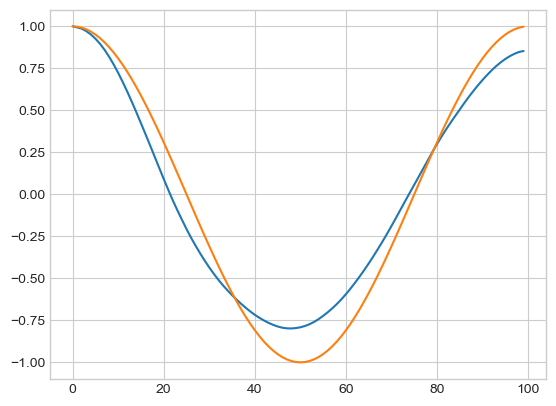

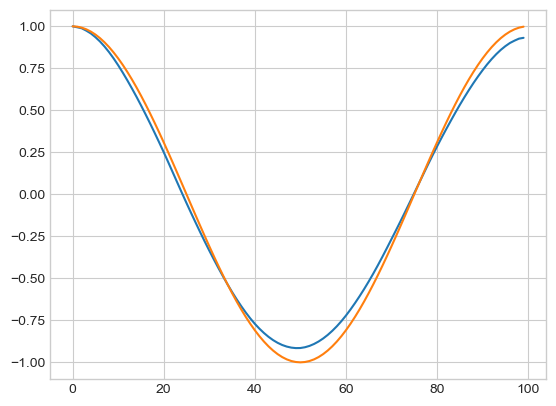

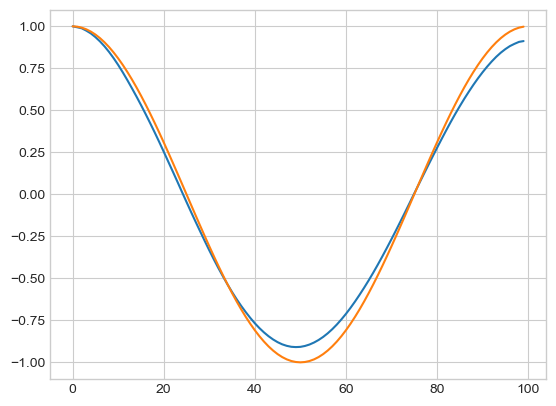

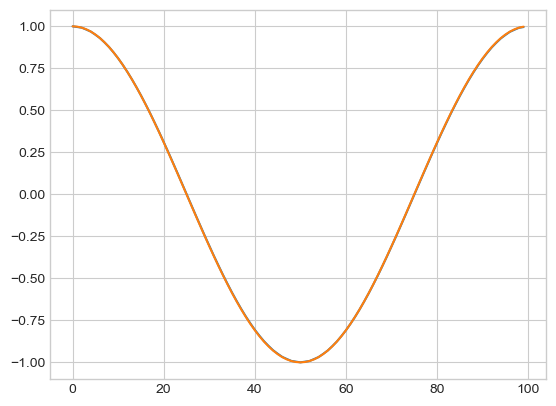

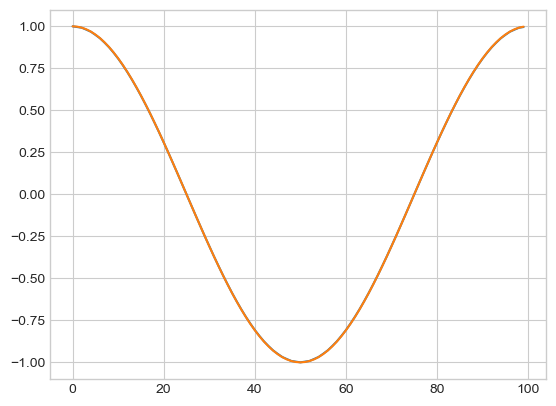

In [7]:
res_phase = 100 #must be even
domain_phase = range(0, stop=2*π, length=res_phase+1)[1:end-1]

for (l_param, (ll_extrema, ll_smoothed_signal)) in d_extrema
    l_p2p_theta = []
    l_p2p_phi = []
    for ((l_extrema_theta, l_extrema_phi),(l_smooth_theta, l_smooth_phi)) in zip(ll_extrema, ll_smoothed_signal)
        
        #find the first peak extremum
        initial_index_theta = l_smooth_theta[l_extrema_theta[1]]>l_smooth_theta[l_extrema_theta[2]] ? 1 : 2
        initial_index_phi = l_smooth_phi[l_extrema_phi[1]]>l_smooth_phi[l_extrema_phi[2]] ? 1 : 2
        #find the peaks idx
        l_idx_peaks_theta = l_extrema_theta[initial_index_theta:2:end]
        l_idx_peaks_phi = l_extrema_phi[initial_index_phi:2:end]
        
        #get a list of all peak to peak signals for theta
        for (idx_peak_theta_1, idx_peak_theta_2) in zip(l_idx_peaks_theta[1:end-1],l_idx_peaks_theta[2:end] )
            curr_p2p = l_smooth_theta[idx_peak_theta_1:idx_peak_theta_2]
            dom = collect(range(0, stop=2*π, length=length(curr_p2p)))
            knots = (dom,)
            f = interpolate(knots, curr_p2p, Gridded(Linear()))
            push!(l_p2p_theta, f(domain_phase))
        end
            
        #same for phi
        for (idx_peak_phi_1, idx_peak_phi_2) in zip(l_idx_peaks_phi[1:end-1],l_idx_peaks_phi[2:end] )
            curr_p2p = l_smooth_phi[idx_peak_phi_1:idx_peak_phi_2]
            dom = collect(range(0, stop=2*π, length=length(curr_p2p)))
            knots = (dom,)
            f = interpolate(knots, curr_p2p, Gridded(Linear()))
            push!(l_p2p_phi, f(domain_phase))
        end
    end
    
    #average and normalize the interpolated p2p signals
    w_theta = mean(l_p2p_theta)
    w_theta = (w_theta.-mean(w_theta))
    w_theta = w_theta/maximum(w_theta)
    
    w_phi = mean(l_p2p_phi)
    w_phi = w_phi.-mean(w_phi)
    w_phi = w_phi/maximum(w_phi)
        
    (name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2)= l_param
    cur_name = name_ω_θ*"_"*name_ω_ϕ*"_"*name_F_θ*"_"*name_F_ϕ*"_"*string(σ_ϕ1)*"_"*string(σ_ϕ2)*"_"*string(σₑ1)*
                       "_"*string(σₑ2)*"_"*string(μₐ1)*"_"*string(γₐ1)*"_"*string(σₐ1)*"_"*string(μᵦ1)*"_"*string(γᵦ1)*
                       "_"*string(σᵦ1)*"_"*string(μₐ2)*"_"*string(γₐ2)*"_"*string(σₐ2)*"_"*string(μᵦ2)*"_"*string(γᵦ2)*
                       "_"*string(σᵦ2)     
    path_plots = "Data/"*cur_name*"/Plots/"
    
    #compare the averaged waveform to the real one
    figure()
    plot(w_theta)
    if l_param[1]=="cos"
        plot(cos.(domain_phase))
    elseif l_param[1]=="triangle"
        plot(circshift([x<=π ? 2*x/π-1 : 2*(2-x/π)-1 for (i,x) in enumerate(domain_phase)], res_phase/2))
    else
        println("not handled")
    end            
    savefig(path_plots*"inf_w_theta.pdf")
    show()
            
    #compare the averaged waveform to the real one
    figure()
    plot(w_phi)
    if l_param[2]=="cos"
        plot(cos.(domain_phase))
    elseif l_param[2]=="triangle"
        plot(circshift([x<=π ? 2*x/π-1 : 2*(2-x/π)-1 for (i,x) in enumerate(domain_phase)], res_phase/2))
    else
        println("not handled")
    end            
    savefig(path_plots*"inf_w_phi.pdf")
    show()
                    
    d_parameters[l_param] =  vcat(d_parameters[l_param], [w_theta, w_phi])
end
        
        

# Store inferred parameters in a file

In [8]:
for (l_param, (Theta, Phi)) in d_parameters
    (name_ω_θ, name_ω_ϕ, name_F_θ, name_F_ϕ, σ_ϕ1, σ_ϕ2, σₑ1, σₑ2, μₐ1,γₐ1, σₐ1, μᵦ1, γᵦ1, σᵦ1, μₐ2,γₐ2, σₐ2, μᵦ2, γᵦ2, σᵦ2)= l_param
    cur_name = name_ω_θ*"_"*name_ω_ϕ*"_"*name_F_θ*"_"*name_F_ϕ*"_"*string(σ_ϕ1)*"_"*string(σ_ϕ2)*"_"*string(σₑ1)*
                       "_"*string(σₑ2)*"_"*string(μₐ1)*"_"*string(γₐ1)*"_"*string(σₐ1)*"_"*string(μᵦ1)*"_"*string(γᵦ1)*
                       "_"*string(σᵦ1)*"_"*string(μₐ2)*"_"*string(γₐ2)*"_"*string(σₐ2)*"_"*string(μᵦ2)*"_"*string(γᵦ2)*
                       "_"*string(σᵦ2)     
    println(cur_name)
        
    path_parameters = "Data/"*cur_name*"/Parameters/"
    
    (sigma_theta, sigma_phi, mu_A_theta, gamma_A_theta, sigma_A_theta, mu_A_phi, gamma_A_phi, sigma_A_phi, mu_B_theta, gamma_B_theta, sigma_B_theta, mu_B_phi, gamma_B_phi, sigma_B_phi, w_theta, w_phi) = d_parameters[l_param] 
        
    #print all parameters in a file (coupling function is not inferred for now)
    writedlm(path_parameters*"inferred.txt", ["none", "none", "none", "none", sigma_theta, sigma_phi, σₑ1, σₑ2, 
                                              mu_A_theta, gamma_A_theta, sigma_A_theta, 
                                              mu_B_theta, gamma_B_theta, sigma_B_theta, 
                                              mu_A_phi, gamma_A_phi, sigma_A_phi, 
                                              mu_B_phi, gamma_B_phi, sigma_B_phi])
    
    writedlm(path_parameters*"inferred_w_theta.txt", w_theta)
    writedlm(path_parameters*"inferred_w_phi.txt", w_phi)
    
end

cos_cos_2gaussians_3gaussians_0.0_0.0_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
cos_cos_2gaussians_3gaussians_0.2_0.2_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
cos_cos_blank_blank_0.2_0.2_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
cos_cos_blank_blank_0.0_0.0_0.0_0.0_1.0_0.1_0.0_0.0_0.1_0.0_1.0_0.1_0.0_0.0_0.1_0.0
